# Gradient Boosting Model Training for SPY Stock Prediction

This notebook trains a gradient boosting classifier (XGBoost or scikit-learn) to predict whether SPY price will increase or decrease over a 5-day horizon.

**Note**: If XGBoost fails to import (due to missing libomp on macOS), the notebook automatically falls back to scikit-learn's GradientBoostingClassifier, which provides similar performance.

## Mathematical Context:
- **Time-Series Split**: Non-shuffled split preserves temporal order to avoid look-ahead bias
  - Train: First 80% of chronological data
  - Test: Last 20% of chronological data
- **XGBoost**: Gradient boosting ensemble method that combines weak learners (decision trees)
  - n_estimators: Number of boosting rounds (trees)
  - learning_rate: Shrinkage factor to prevent overfitting
- **Evaluation Metrics**:
  - Precision: TP / (TP + FP) - Accuracy of positive predictions
  - Recall: TP / (TP + FN) - Ability to find all positives
  - F1-Score: 2 * (Precision * Recall) / (Precision + Recall) - Harmonic mean


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Tuple
import os
import sys

# Try to set environment variable for libomp if on macOS
if sys.platform == 'darwin':
    # Common locations for libomp
    possible_libomp_paths = [
        '/opt/homebrew/opt/libomp/lib/libomp.dylib',  # Apple Silicon Homebrew
        '/usr/local/opt/libomp/lib/libomp.dylib',     # Intel Homebrew
        '/usr/local/lib/libomp.dylib',
    ]
    for path in possible_libomp_paths:
        if os.path.exists(path):
            os.environ['DYLD_LIBRARY_PATH'] = os.path.dirname(path)
            break

# Import xgboost with fallback to scikit-learn if it fails
USE_XGBOOST = True
xgb = None
try:
    import xgboost as xgb
    print("✓ XGBoost imported successfully")
except Exception as e:
    # Catch any exception during import (ImportError, OSError, XGBoostError, etc.)
    error_str = str(e)
    error_type = type(e).__name__
    
    # Check for various XGBoost/libomp related errors
    libomp_keywords = ["libomp", "libomp.dylib", "OpenMP", "XGBoostError", "libxgboost", "Library could not be loaded"]
    
    if any(keyword in error_str for keyword in libomp_keywords) or "XGBoostError" in error_type:
        print("=" * 70)
        print("⚠ XGBoost import failed due to missing libomp (OpenMP) library.")
        print("Switching to scikit-learn's GradientBoostingClassifier as alternative.")
        print("=" * 70)
        print(f"Error type: {error_type}")
        print(f"Error: {error_str[:200]}...")
        print("\nTo use XGBoost instead, install libomp:")
        print("  1. Install Homebrew: /bin/bash -c \"$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)\"")
        print("  2. Install libomp: brew install libomp")
        print("  3. Restart kernel and re-run")
        print("=" * 70)
        USE_XGBOOST = False
        xgb = None
    else:
        # Re-raise if it's a different error we don't know how to handle
        print(f"Unexpected error importing XGBoost: {error_type}: {error_str}")
        raise

# Import scikit-learn as fallback
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Create a wrapper class to use either XGBoost or sklearn
if USE_XGBOOST and xgb is not None:
    ModelClass = xgb.XGBClassifier
    print("Using XGBoost for training")
else:
    ModelClass = GradientBoostingClassifier
    USE_XGBOOST = False  # Ensure flag is set correctly
    print("Using scikit-learn GradientBoostingClassifier for training")


⚠ XGBoost import failed due to missing libomp (OpenMP) library.
Switching to scikit-learn's GradientBoostingClassifier as alternative.
Error type: XGBoostError
Error: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp...

To use XGBoost instead, install libomp:
  1. Install Homebrew: /bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"
  2. Install libomp: brew install libomp
  3. Restart kernel and re-run
Using scikit-learn GradientBoostingClassifier for training


In [2]:
def load_processed_data(filepath: str = "data/processed/spy_featured.csv") -> pd.DataFrame:
    """
    Load processed feature data from CSV.
    
    Args:
        filepath: Path to processed CSV file
    
    Returns:
        DataFrame with features and target
    """
    # Try multiple possible locations
    # Find project root
    cwd = Path.cwd()
    project_root = None
    for check_path in [cwd, cwd.parent, cwd.parent.parent]:
        if (check_path / "data").exists() or (check_path / "requirements.txt").exists():
            project_root = check_path
            break
    if project_root is None:
        project_root = cwd
    
    possible_paths = [
        Path(filepath),
        Path("../data/processed/spy_featured.csv"),
        Path("../../data/processed/spy_featured.csv"),
        project_root / "data" / "processed" / "spy_featured.csv",
    ]
    
    df = None
    for path in possible_paths:
        if path.exists():
            df = pd.read_csv(path)
            print(f"✓ Loaded data from: {path}")
            break
    
    if df is None:
        raise FileNotFoundError(
            f"Could not find processed data file. Tried: {possible_paths}"
        )
    
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
    
    return df


def prepare_features_target(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Split data into features (X) and target (y).
    
    Excludes time column and target column from features.
    
    Args:
        df: DataFrame with features and target
    
    Returns:
        Tuple of (features DataFrame, target Series)
    """
    # Exclude time and target columns from features
    feature_columns = [col for col in df.columns if col not in ['time', 'target']]
    
    X = df[feature_columns].copy()
    y = df['target'].copy()
    
    print(f"✓ Prepared features and target")
    print(f"  Features: {len(feature_columns)} columns")
    print(f"  Feature columns: {feature_columns}")
    print(f"  Target distribution: {y.value_counts().to_dict()}")
    
    return X, y


def time_series_split(X: pd.DataFrame, y: pd.Series, train_ratio: float = 0.8) -> Tuple:
    """
    Perform non-shuffled time-series split.
    
    Critical for time-series data to avoid look-ahead bias.
    Preserves chronological order: train on past, test on future.
    
    Args:
        X: Features DataFrame
        y: Target Series
        train_ratio: Proportion of data for training (default: 0.8)
    
    Returns:
        Tuple of (X_train, X_test, y_train, y_test)
    """
    split_idx = int(len(X) * train_ratio)
    
    X_train = X.iloc[:split_idx].copy()
    X_test = X.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_test = y.iloc[split_idx:].copy()
    
    print(f"✓ Time-series split (non-shuffled)")
    print(f"  Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  Test: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
    print(f"  Train indices: {X_train.index[0]} to {X_train.index[-1]}")
    print(f"  Test indices: {X_test.index[0]} to {X_test.index[-1]}")
    
    return X_train, X_test, y_train, y_test


## Load and Prepare Data


In [3]:
# Load processed data
df = load_processed_data("/Users/rakehsaleem/ai-trading-lab/src/features/data/processed/spy_featured.csv")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())


✓ Loaded data from: ../../data/processed/spy_featured.csv
  Shape: (4951, 11)
  Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi_14', 'ema_20', 'ema_50', 'atr', 'target']

First 5 rows:


,time,open,high,low,close,volume,rsi_14,ema_20,ema_50,atr,target
0,2006-04-25 00:00:00-04:00,90.818981,90.874427,90.042753,90.354630,84359800,54.184452,90.148349,89.540572,0.805781,1
1,2006-04-26 00:00:00-04:00,90.444723,90.888282,90.306112,90.375412,67262400,54.412988,90.169974,89.573311,0.789808,1
2,2006-04-27 00:00:00-04:00,90.028863,91.227869,89.814015,90.812027,124478600,59.036054,90.231122,89.621888,0.834383,1
3,2006-04-28 00:00:00-04:00,90.645701,91.311046,90.590265,91.116989,55854400,61.939386,90.315490,89.680519,0.826269,1
4,2006-05-01 00:00:00-04:00,91.116994,91.345707,90.319976,90.375412,64990300,52.242845,90.321197,89.707770,0.840516,1


In [4]:
# Prepare features and target
X, y = prepare_features_target(df)

# Perform time-series split (80% train, 20% test)
# CRITICAL: Non-shuffled to preserve temporal order and avoid look-ahead bias
X_train, X_test, y_train, y_test = time_series_split(X, y, train_ratio=0.8)


✓ Prepared features and target
  Features: 9 columns
  Feature columns: ['open', 'high', 'low', 'close', 'volume', 'rsi_14', 'ema_20', 'ema_50', 'atr']
  Target distribution: {1: 2980, 0: 1971}
✓ Time-series split (non-shuffled)
  Train: 3960 samples (80.0%)
  Test: 991 samples (20.0%)
  Train indices: 0 to 3959
  Test indices: 3960 to 4950


## Train XGBoost Model


In [5]:
# Initialize model (XGBoost or scikit-learn GradientBoosting)
# n_estimators: Number of boosting rounds (trees)
# learning_rate: Shrinkage factor to prevent overfitting

if USE_XGBOOST:
    model = ModelClass(
        n_estimators=100,
        learning_rate=0.05,
        random_state=42,
        eval_metric='logloss'  # For binary classification
    )
    model_name = "XGBoost"
else:
    model = ModelClass(
        n_estimators=100,
        learning_rate=0.05,
        random_state=42,
        loss='log_loss'  # For binary classification
    )
    model_name = "GradientBoostingClassifier"

print(f"Training {model_name} model...")
print(f"  n_estimators: {model.n_estimators}")
print(f"  learning_rate: {model.learning_rate}")

# Train the model
model.fit(X_train, y_train)

print(f"✓ {model_name} model training complete!")


Training GradientBoostingClassifier model...
  n_estimators: 100
  learning_rate: 0.05
✓ GradientBoostingClassifier model training complete!


## Evaluate Model


In [6]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Training Set Performance:")
print("=" * 50)
print("\nConfusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=['Price Down (0)', 'Price Up (1)']))


Training Set Performance:

Confusion Matrix:
[[ 315 1257]
 [  61 2327]]

Classification Report:
                precision    recall  f1-score   support

Price Down (0)       0.84      0.20      0.32      1572
  Price Up (1)       0.65      0.97      0.78      2388

      accuracy                           0.67      3960
     macro avg       0.74      0.59      0.55      3960
  weighted avg       0.72      0.67      0.60      3960



In [7]:
print("\n" + "=" * 50)
print("Test Set Performance:")
print("=" * 50)
print("\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Price Down (0)', 'Price Up (1)']))



Test Set Performance:

Confusion Matrix:
[[ 99 300]
 [181 411]]

Classification Report:
                precision    recall  f1-score   support

Price Down (0)       0.35      0.25      0.29       399
  Price Up (1)       0.58      0.69      0.63       592

      accuracy                           0.51       991
     macro avg       0.47      0.47      0.46       991
  weighted avg       0.49      0.51      0.49       991



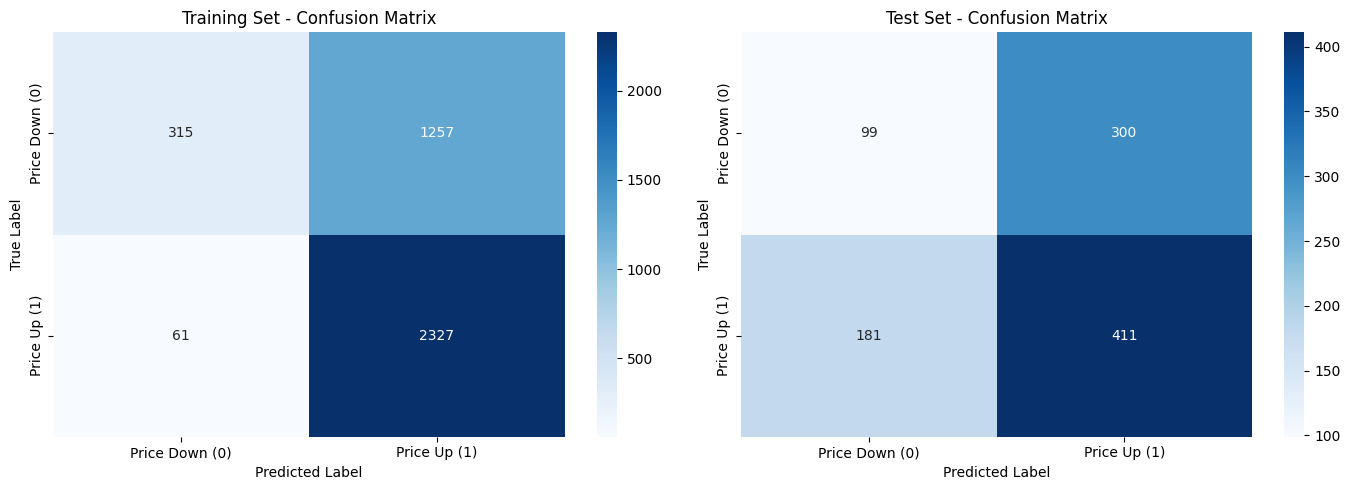

In [8]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Price Down (0)', 'Price Up (1)'],
            yticklabels=['Price Down (0)', 'Price Up (1)'])
axes[0].set_title('Training Set - Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Test set confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Price Down (0)', 'Price Up (1)'],
            yticklabels=['Price Down (0)', 'Price Up (1)'])
axes[1].set_title('Test Set - Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


## Save Model


In [9]:
# Find project root to ensure models are saved to root models/ directory
cwd = Path.cwd()
project_root = None

# Check current directory and parents for project root
for check_path in [cwd, cwd.parent, cwd.parent.parent, cwd.parent.parent.parent]:
    if (check_path / "models").exists() or (check_path / "requirements.txt").exists():
        project_root = check_path
        break

# If no project root found, use current directory
if project_root is None:
    project_root = cwd

# Create models directory at project root if it doesn't exist
models_dir = (project_root / "models").resolve()
models_dir.mkdir(exist_ok=True)

# Save model (different methods for XGBoost vs sklearn)
if USE_XGBOOST:
    model_path = models_dir / "xgboost_spy_v1.json"
    model.save_model(str(model_path))
    print(f"✓ XGBoost model saved to: {model_path}")
else:
    # For sklearn, use joblib/pickle
    import joblib
    model_path = models_dir / "xgboost_spy_v1.pkl"
    joblib.dump(model, model_path)
    print(f"✓ GradientBoosting model saved to: {model_path}")
    print("  Note: Saved as .pkl instead of .json (sklearn format)")

print(f"  Model file size: {model_path.stat().st_size / 1024:.2f} KB")

# Also save feature names for reference
feature_names_path = models_dir / "xgboost_spy_v1_features.txt"
with open(feature_names_path, 'w') as f:
    f.write('\n'.join(X.columns.tolist()))
print(f"✓ Feature names saved to: {feature_names_path}")


✓ GradientBoosting model saved to: /Users/rakehsaleem/ai-trading-lab/src/models/xgboost_spy_v1.pkl
  Note: Saved as .pkl instead of .json (sklearn format)
  Model file size: 139.32 KB
✓ Feature names saved to: /Users/rakehsaleem/ai-trading-lab/src/models/xgboost_spy_v1_features.txt



Feature Importance (Top 10):


,feature,importance
7,ema_50,0.240021
8,atr,0.167564
4,volume,0.139302
6,ema_20,0.129318
5,rsi_14,0.128924
3,close,0.096867
1,high,0.062752
0,open,0.028471
2,low,0.006781


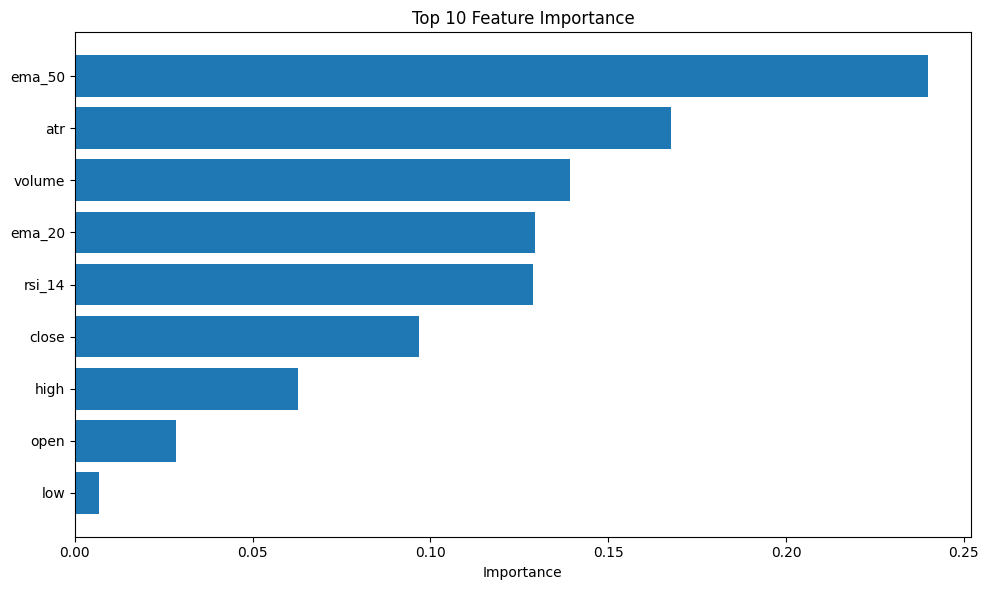

In [10]:
# Display feature importance (works for both XGBoost and sklearn)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 10):")
print("=" * 50)
display(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
